<a href="https://colab.research.google.com/github/fatusilva/test/blob/master/TFM_CSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Fin de Máster (TFM)
## Predicción de la satisfacción del cliente (CSAT) en un Contact Center
---
Este notebook sigue la misma estructura aplicada en los trabajos prácticos del máster, adaptado para cargar el archivo desde Google Drive mediante enlace público.

In [1]:
!pip -q install xgboost imbalanced-learn


In [2]:
import numpy as np
import pandas as pd
import re
from datetime import datetime

# Modelado / Métricas
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Opcional (plots)
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
from xgboost import XGBClassifier

pd.set_option('display.max_colwidth', 120)
pd.set_option('display.max_columns', 200)


In [4]:
from google.colab import files
uploaded = files.upload()  # subí tu .xlsx
FILE_PATH = list(uploaded.keys())[0]
SHEET_NAME = None  # o el nombre de la hoja si querés especificar

 #from google.colab import drive
 #drive.mount('/content/drive')
 #FILE_PATH = '/content/drive/MyDrive/BaseEncuestasClientes.xlsx'
# SHEET_NAME = None


Saving BaseEncuestasClientes.xlsx to BaseEncuestasClientes.xlsx


In [5]:
import pandas as pd

# Ver qué hojas tiene el archivo
xl = pd.ExcelFile(FILE_PATH)
print("Hojas encontradas:", xl.sheet_names)

# Usa la primera hoja (o cambia el índice 0 por 1, 2, etc. si querés otra)
df = pd.read_excel(FILE_PATH, sheet_name=0, header=1)

# Normalizar nombres
df.columns = [str(c).strip() for c in df.columns]

print("Shape inicial:", df.shape)
print("Primeras columnas:", df.columns[:10].tolist())
df.head()

Hojas encontradas: ['Sheet0']
Shape inicial: (38005, 104)
Primeras columnas: ['Fecha de inicio', 'Fecha de finalización', 'Progreso', 'Duración (en segundos)', 'Finalizado', 'Fecha registrada', 'ID de respuesta', 'Apellido del destinatario', 'Nombre del destinatario', 'Referencia a datos externos']


,Fecha de inicio,Fecha de finalización,Progreso,Duración (en segundos),Finalizado,Fecha registrada,ID de respuesta,Apellido del destinatario,Nombre del destinatario,Referencia a datos externos,Latitud de la ubicación,Longitud de la ubicación,Canal de la distribución,Idioma del usuario,¿Resolvimos tu consulta?,¿Cómo calificas tu experiencia en la sucursal?,¿Cómo calificas el tiempo de espera en la sucursal?,¿Cómo calificas la organización de la sucursal para atender tu consulta?,¿Cómo calificas la comodidad de las instalaciones en la sucursal?,¿Cómo calificás la atención recibida por nuestro ejecutivo/a en la sucursal?,¿Cómo calificás la atención recibida por nuestro equipo de experiencia?,¿Algo más que nos quieras compartir?,genero,rango_etario,cluster,ciudad,cuenta_creada,tarjeta_fisica_credito,ultimo_movimiento_tc,tarjeta_fisica_debito,oferta_preaprobada_activa_prestamo,prestamo_activo,ultimo_movimiento_qr,ultima_transferencia,contrato_unico_firmado,ultimo_pago_servicios,tarjeta_duocard,oferta_preaprobada_activa_tc,derivacion_caso,grupo_producto,motivo_contacto,motivo_reclamo,resolucion_favor_cliente,ticket_id,tiempo_resolucion,ya_es_cliente,agente_asignado_vinanzas,agente_asignado_operaciones,persona_asignada,sent_date,canal_de_transacción,departamento,cliente_origen,bandeja,canal_ticket,Formulario CSAT,Etiquetas,agente_asignado,Estado,CaseNumber_sf,Id_sf,Origin_sf,Reason_sf,Executive_sf,sourceObject_sf,sucursal_sf,Producto_sf,Prioridad_sf,Descripcion_sf,Type_sf,Timeescalated_sf,Subproduct_sf,ROTDerivation_sf,ejecutivo_email_sf,fecha_creacion_caso_sf,fecha_cierre_caso_sf,Recontacto_sf,segmento,SurveyID,recordType,CSAT Atención Digital N,CSAT Atención Sucursal N,CSAT Comodidad Suc N,CSAT General,CSAT Organización Suc N,CSAT Sucursal N,CSAT Tiempo Suc N,Q3 - Actionability,Q3 - Effort,Q3 - Effort Numeric,Q3 - Emotion Intensity,Q3 - Emotion,Q3 - Parent Topics,Q3 - Sentiment Polarity,Q3 - Sentiment Score,Q3 - Sentiment,Q3 - Topic Sentiment Label,Q3 - Topic Sentiment Score,Q3 - Topics,Producto_type_sf,Regiones,Tipo de Atención,Regiones_sf,Q3 - Topic Hierarchy Level 1
0,2024-12-31 22:39:41,2024-12-31 22:40:06,100,25,True,2024-12-31 22:40:07.404,R_3q5vTMtZYmzSu3v,ALSINA,MARIA,NaN,-23.3333,-58.0000,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,Gracias por la ayuda brindada! Feliz año nuevo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deriva_a_sin_derivación,NaN,NaN,NaN,NaN,3685286.0,NaN,ya_es_cliente,NaN,NaN,Enzo Florentin,NaN,NaN,NaN,NaN,redes_sociales_c,NaN,formulario_digital,buenas ci_actualizado consulta cuenta deriva_a_sin_derivación desvio_automatico email_cst formulario_digital motivo_...,NaN,Cerrado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SV_e96vbeWvrEmvs10,Satisfaccion_y_resolucion_de_caso,5.0,NaN,NaN,5.0,NaN,NaN,NaN,other,Easy,1.0,Medium,Thankfulness,NaN,0.0,1.0,Positive,NaN,NaN,Unknown,NaN,Sin categoría,Digital y Telefónico,NaN,NaN
1,2024-12-31 23:00:38,2024-12-31 23:00:48,100,9,True,2024-12-31 23:00:48.963,R_3EuIo9OuYEyUwhk,LEGUIZAMON,MARIO,NaN,-25.2869,-57.6511,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redes_sociales_,tarjetas__,NaN,NaN,NaN,3684772.0,NaN,ya_es_cliente,NaN,NaN,Gerson Rodas,NaN,canal_tx_no_aplica,NaN,NaN,redes_sociales_c,NaN,formulario_digital,_no_ canal_tx_no_aplica casuisticas_loyalty_beneficios_reintegro_historial_de_reintegro chatinapp ci_actualizado con...,NaN,Cerrado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SV_e96vbeWvrEmvs10,Satisfaccion_y_resolucion_de_caso,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sin categoría,Digital y Telefónico,NaN,NaN
2,2024-12-31 23:06:09,2024-12-31 23:06:47,100,37,True,2024-12-31 23:06:47.916,R_3kyS43P8QCgHTS1,ESCOBAR,ALMA,NaN,-25.2869,-57.6511,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,Feliz Año 2025!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,segunda_linea,

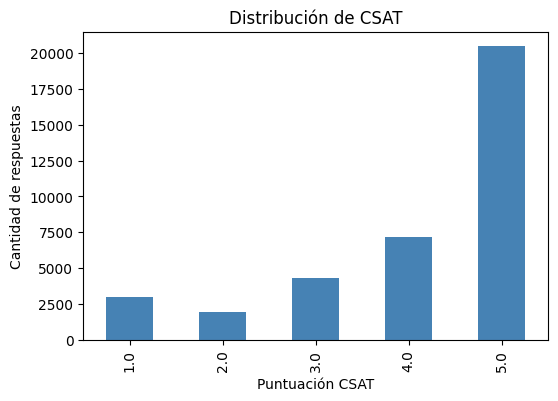

In [6]:
# 📊 Análisis exploratorio
plt.figure(figsize=(6,4))
df['CSAT General'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Distribución de CSAT')
plt.xlabel('Puntuación CSAT')
plt.ylabel('Cantidad de respuestas')
plt.show()

In [ ]:
# 🔠 Codificación de variables categóricas
cat_cols = ['Canal', 'Motivo_contacto', 'Motivo_reclamo', 'Departamento', 'género', 'rango_etario', 'cluster', 'ciudad']
cat_cols = [col for col in cat_cols if col in df.columns]

# Derivar variables temporales ANTES de codificar
if 'Fecha registrada' in df.columns:
    df['dia_semana'] = df['Fecha registrada'].dt.dayofweek
    df['hora'] = df['Fecha registrada'].dt.hour
    df['mes'] = df['Fecha registrada'].dt.month
    df = df.drop(columns=['Fecha registrada'])

# Codificación de variables categóricas
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [ ]:
# 📂 División en train/test para modelar
X = df_encoded.drop(columns=['CSAT General', 'CSAT_binario', '¿Resolvimos tu consulta?'], errors='ignore')
y = df_encoded['CSAT_binario']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Conjunto de entrenamiento:', X_train.shape)
print('Conjunto de prueba:', X_test.shape)

Conjunto de entrenamiento: (115080, 581)
Conjunto de prueba: (28771, 581)


In [ ]:
# Ver columnas tipo datetime en X_train
datetime_cols = X_train.select_dtypes(include=['datetime64']).columns
print("Columnas datetime detectadas:", list(datetime_cols))

# Detectar y eliminar automáticamente columnas datetime
datetime_cols = X_train.select_dtypes(include=['datetime64']).columns
print("Eliminando columnas datetime:", list(datetime_cols))

X_train = X_train.drop(columns=datetime_cols, errors='ignore')
X_test = X_test.drop(columns=datetime_cols, errors='ignore')


Columnas datetime detectadas: ['Fecha de inicio', 'Fecha de finalización']
Eliminando columnas datetime: ['Fecha de inicio', 'Fecha de finalización']


In [ ]:
# 🌲 Entrenamiento de modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

ValueError: could not convert string to float: 'IP Address'

In [ ]:
# 🔍 Interpretabilidad con SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

✅ *Este notebook aplica el flujo aprendido en los trabajos prácticos del máster, y permite iniciar el análisis directamente desde un archivo Excel público de Google Drive.*